In [121]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split

## The data

The data is from electron microscopy - images of grpahene sheets. The typical image is $(256, 256)$ but we would like to take small patches of this and identify - is there a defect in the patch.

Lets go through a few of those things. Below we will look at 

* A full image
* A patch of an image with no defects
* A patch with a defect

### Full image

In [122]:
graphene = np.load('full-stack.npy') ## This has 180 different microgrpahs each (256, 256)
sample = np.squeeze(graphene[54])

In [123]:
print(sample.shape)

(256, 256)


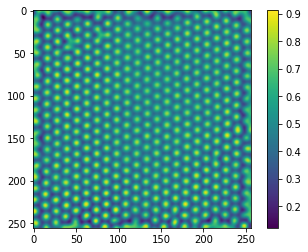

In [124]:
plt.imshow(sample)
plt.colorbar()

#### Description
The blue (high electron density) correspnds to atoms and the green correspnds to background.

You can see that in the middle of the sheet most of it is a pretty regular array of hexagons, this is what we exepct for the perfect lattice. You will also hopefully see some spots where the hexagon is broken. This many of these are the result of missing atom defects. 

Notice the edges look a bit weird too. This is standard, and we will generally ignore the edges when analysing.



### Perfect patch

There is a training dataset of perfect patches 

In [125]:
pp = np.load('./perfect_patches.npy')
perfect_sample = pp[0] 
print(pp.shape)

(2279, 48, 48)


(0.12360269, 0.0072767125, 24.593985, 24.593985, 3.0398827, 0.17896335)

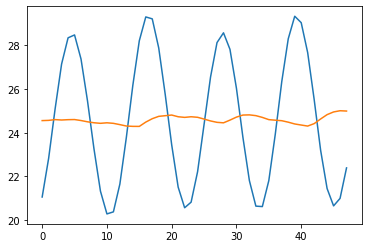

In [126]:
n1 = np.sum(perfect_sample, axis=0)
plt.plot(n1)
e1 = np.std(n1)/np.mean(n1)
n2 = np.sum(perfect_sample, axis=1)
e2 = np.std(n2)/np.mean(n2)
plt.plot(n2)
e1, e2, np.mean(n1), np.mean(n2), np.std(n1), np.std(n2)


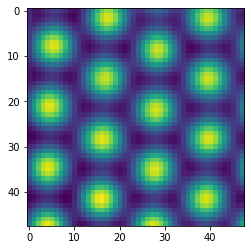

In [127]:
plt.imshow(perfect_sample)

### Defect patch

There is also a set of defective patches. Note - these are for testing only, not for training. I guess we could imagine training a classifier on these and the perfect patches - but that would be no fun :)

In [128]:
dp = np.load('./defect_patches.npy')
defect_sample = dp[0] 
print(dp.shape)


(32, 48, 48)


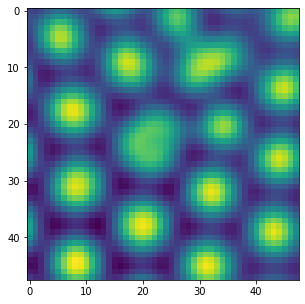

In [129]:
plt.figure(figsize=(5, 5))
plt.imshow(defect_sample)

(0.1249781, 0.03558564, 25.00563, 25.005632, 3.1251562, 0.8898415)

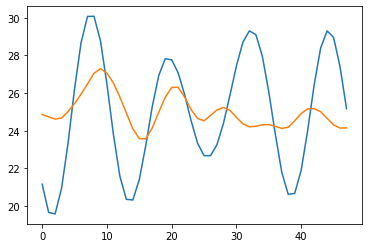

In [130]:
n1 = np.sum(defect_sample, axis=0)
plt.plot(n1)
e1 = np.std(n1)/np.mean(n1)
n2 = np.sum(defect_sample, axis=1)
e2 = np.std(n2)/np.mean(n2)
plt.plot(n2)
e1, e2, np.mean(n1), np.mean(n2), np.std(n1), np.std(n2)


Get patches perfect and defect, and put them randomly in a list, with the ground truth saved

In [131]:
patches = np.concatenate([pp, dp])
gt = np.concatenate([np.zeros(len(pp)), np.ones(len(dp))])
xy = list(zip(patches, gt)) # put labels with data in (data, label) tuple
random.shuffle(xy) # shuffle the tuples

In [132]:
patches, gt = list(zip(*xy)) # unzip the tuples to get patches and ground truths as vectors

Splitting into training and testing

# Helper functions
The below fonctions help with the processing.

#### Model helper functions

In [133]:
def std(image) -> tuple:
    """Returns the standard deviations along the x and y axes.

    Args:
        image (Array): image to compute its standard deviations.

    Returns:
        tuple: (0-axis std, 1-axis std).
    """
    image1 = np.sum(image,axis=1)
    image0 = np.sum(image,axis=0)
    stdim0 = np.std(image0)
    stdim1 = np.std(image1)
    return (stdim0,stdim1)

### Image helper functions

In [134]:
def flip_horizontally(imgs):
    flipped = np.array([cv2.flip(img, 0) for img in imgs])
    return flipped

def flip_vertically(imgs):
    flipped = np.array([cv2.flip(img, 1)  for img in imgs])
    return flipped

def blur(imgs, kernel = (5,5)):
    blurred = np.array([cv2.blur(img, kernel) for img in imgs])
    return blurred

def augment(defect_imgs):
    """Augments the dataset by applying a series of transformations.

    Args:
        defect_imgs (np.array): array of images to augment.

    Returns:
        np.array: augmented array.
    """
    # Let's first apply some initial transformations.
    blurred = blur(defect_imgs)
    flip_h = flip_horizontally(defect_imgs)
    flip_v = flip_vertically(defect_imgs)
    flip_h_v = flip_horizontally(flip_v)
    b_h = blur(flip_h)
    b_v = blur(flip_v)
    b_h_v = blur(flip_h_v)
    data = [
        defect_imgs,
        blurred,
        flip_h,
        flip_v,
        flip_h_v,
        b_h,
        b_v,
        b_h_v,
            ]
    
    # Let's now apply mathematical transformations to the newly 
    # augmented data set.
    cosed = []
    sined = []
    taned = []
    exped = []
    
    for sub_data in data:
        cosed.append(np.cos(sub_data))
        sined.append(np.sin(sub_data))
        taned.append(np.tan(sub_data))
        exped.append(np.exp(sub_data))
        
    data = np.concatenate((*data, *cosed, *sined, *taned, *exped), axis=0)
    data = np.concatenate((data, blur(data, kernel=[7,7])), axis=0)
    
    return data

# Data Augmentation
TODO: Here we augment the defect images to have a 50-50 ratio between the perfect and defect images.

In [135]:
limit = 2000
X_defect = augment(dp)[:limit]

# Data Splitting
Here we are splitting the data into a:
- training data set,
- testing data set.

In [136]:
# Perfect patches
X_perfect = pp[:limit]
y_perfect = np.zeros(len(X_perfect))
X_perfect_train, X_perfect_test, y_perfect_train, y_perfect_test = train_test_split(
    X_perfect,
    y_perfect,
    test_size=0.20,
    random_state=42,)

In [137]:
# Defect patches
y_defect = np.ones(len(X_defect))
X_defect_train, X_defect_test, y_defect_train, y_defect_test = train_test_split(
    X_defect, 
    y_defect, 
    test_size=0.20, 
    random_state=42,)

In [138]:
# Concatenate the perfect and defect patches into one training and testing data sets.
X_train = np.concatenate((X_perfect_train, X_defect_train), axis = 0)
y_train = np.concatenate((y_perfect_train, y_defect_train), axis = 0)
print(f"X_train :\t {X_train.shape} | y_train :\t {y_train.shape}")

X_test = np.concatenate((X_perfect_test, X_defect_test), axis = 0)
y_test = np.concatenate((y_perfect_test, y_defect_test), axis = 0)
print(f"X_test :\t {X_test.shape} | y_test :\t {y_test.shape}")

X_train :	 (3200, 48, 48) | y_train :	 (3200,)
X_test :	 (800, 48, 48) | y_test :	 (800,)


In [140]:
ppL = []
dpL = []
for _, img in enumerate(X_perfect_train):
    ppL.append(std(img))
for _, img in enumerate(X_defect_train):
    dpL.append(std(img))


In [141]:
dpL

[(3.3555954, 1.0305586),
 (2.2550755, 0.8382502),
 (3.319643, 1.0979116),
 (2.1651163, 0.7003762),
 (1.2808434, 0.3635257),
 (3.5951748, 1.3119216),
 (1.2337376, 0.65405726),
 (1.4103351, 0.47705877),
 (2.8398268, 1.0583787),
 (3.9916644, 1.3155134),
 (2.3752422, 0.8600133),
 (2.1326504, 0.6504271),
 (0.7582699, 0.27332157),
 (2.9522269, 1.1946098),
 (3.251555, 0.90517336),
 (1.5970172, 0.69855696),
 (1.716908, 0.4435195),
 (2.457604, 0.78936374),
 (2.608346, 0.7495646),
 (0.688952, 0.32162583),
 (2.3874328, 0.86820006),
 (1.4064487, 0.47744974),
 (1.7479478, 0.7856364),
 (2.481126, 0.8012679),
 (1.7479483, 0.78563637),
 (1.4235263, 0.609474),
 (1.2361299, 0.60683805),
 (5.1116266, 1.5092682),
 (2.982574, 1.1876925),
 (1.4222435, 0.74847746),
 (1.0856705, 0.43400306),
 (1.0092137, 0.3803545),
 (1.6937222, 0.8170234),
 (2.3953607, 0.8621343),
 (1.0796934, 0.55022556),
 (1.3786023, 0.532565),
 (4.746071, 1.6398352),
 (3.0980809, 1.0446618),
 (1.4172931, 0.47557834),
 (1.4903386, 0.627638

In [142]:
ppL

[(3.086302, 0.21055739),
 (3.0493562, 0.20019011),
 (2.9537585, 0.20983464),
 (3.127813, 0.24595435),
 (2.9384415, 0.21068376),
 (3.0354314, 0.19353294),
 (3.294414, 0.17065528),
 (2.924322, 0.23114574),
 (3.126634, 0.2189127),
 (3.174659, 0.13527079),
 (3.1183236, 0.21083534),
 (2.9688373, 0.21795438),
 (3.2098708, 0.1527496),
 (3.0586553, 0.18615952),
 (2.9401145, 0.30422994),
 (3.133358, 0.20872489),
 (2.9265873, 0.23511678),
 (2.9377177, 0.21088977),
 (2.9671557, 0.2507879),
 (3.2417111, 0.17984375),
 (3.076188, 0.20983599),
 (2.9864337, 0.2853519),
 (3.152084, 0.17058505),
 (3.134409, 0.11409057),
 (3.1268635, 0.16820833),
 (3.198814, 0.17994037),
 (3.10881, 0.20535974),
 (3.0788047, 0.16850817),
 (3.063423, 0.14515567),
 (3.174388, 0.24111252),
 (3.021901, 0.23212641),
 (3.2338548, 0.14316404),
 (3.1986883, 0.13951397),
 (3.0838766, 0.15434808),
 (3.234331, 0.19926065),
 (3.389043, 0.2133222),
 (3.0664413, 0.15638946),
 (3.053584, 0.18820103),
 (3.0093842, 0.21671472),
 (3.203770